# ACTIVE USER GROWTH PREDICTION

In [2]:
import numpy as np
import pandas as pd
import os
from datetime import datetime, timedelta
import calendar

In [3]:
from google.analytics.data_v1beta import BetaAnalyticsDataClient
from google.analytics.data_v1beta.types import (
    DateRange,
    Dimension,
    Metric,
    RunReportRequest,
    OrderBy,
    CohortSpec,
    Cohort,
    CohortsRange,
)

In [4]:
## Set up global variables

os.environ["GOOGLE_APPLICATION_CREDENTIALS"] = 'service_account.json'
property_id = '468166589'

client = BetaAnalyticsDataClient()

In [11]:
request = RunReportRequest(
        property='properties/'+property_id,
        dimensions=[Dimension(name="yearMonth"), ],
        metrics=[Metric(name="activeUsers")],
        date_ranges=[DateRange(start_date="2024-12-01", end_date="2025-01-31")],
    )

# Fetch the response
response = client.run_report(request)

In [12]:
# Convert response to DataFrame
data = []
for row in response.rows:
    data.append([row.dimension_values[0].value, int(row.metric_values[0].value)])

df = pd.DataFrame(data, columns=["yearMonth", "active_users"])
df

,yearMonth,active_users
0,202412,18997
1,202501,18954


In [13]:
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression

# Convert yearMonth to integer
df["yearMonth"] = df["yearMonth"].astype(int)

# Prepare features (X) and target variable (y)
X = df[["yearMonth"]].values.reshape(-1, 1)  # Ensure X is in correct shape
y = df["active_users"]  # Target variable

# Train Linear Regression model
model = LinearRegression()
model.fit(X, y)

# Predict next month's users
latest_month_num = df["yearMonth"].max()  # Get the latest YYYYMM
latest_year = latest_month_num // 100
latest_month = latest_month_num % 100

# Move to the next month
if latest_month == 12:
    next_year = latest_year + 1
    next_month = 1
else:
    next_year = latest_year
    next_month = latest_month + 1

next_month_num = next_year * 100 + next_month  # Convert to YYYYMM format

# Predict
next_month_df = np.array([[next_month_num]])  # Ensure correct shape
predicted_users = model.predict(next_month_df)

# Print the prediction
print(f"Predicted Active Users for {calendar.month_name[next_month]} {next_year}: {int(predicted_users[0])}")

# Visualization

Predicted Active Users for February 2025: 18953


In [19]:
#model.intercept_
#model.coef_


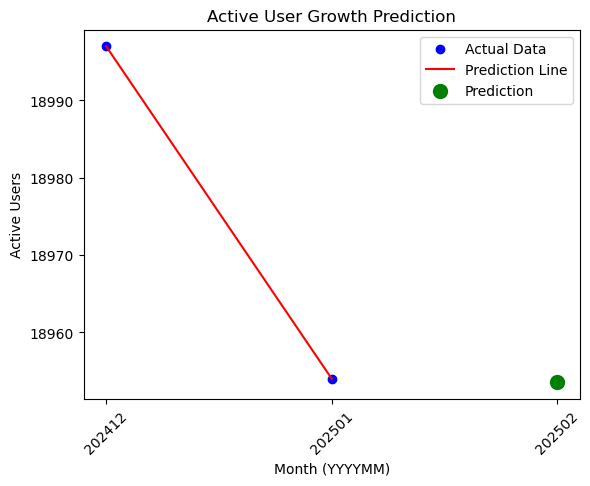

In [14]:
# Convert yearMonth to string for proper labeling
df["yearMonth"] = df["yearMonth"].astype(str)
next_month_num = str(next_month_num)

# Visualization with fixed X-axis labels
plt.scatter(df["yearMonth"], df["active_users"], color="blue", label="Actual Data")
plt.plot(df["yearMonth"], model.predict(X), color="red", label="Prediction Line")
plt.scatter(next_month_num, predicted_users, color="green", marker="o", s=100, label="Prediction")

plt.xlabel("Month (YYYYMM)")
plt.ylabel("Active Users")
plt.title("Active User Growth Prediction")
plt.xticks(ticks=df["yearMonth"].tolist() + [next_month_num], labels=df["yearMonth"].tolist() + [next_month_num], rotation=45)
plt.legend()
plt.show()
